In [1]:
!pip install --upgrade scikit-learn imblearn

scikit-learn version: 1.6.1
Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}

Decision Tree Classification Report:

              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00        18
   unhealthy       1.00      1.00      1.00        18

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Decision Tree ROC-AUC Score: 1.0

Decision Tree Cross-Validation F1-Weighted Scores: [1.         1.         0.92857143 1.         1.        ]
Mean CV F1-Weighted Score: 0.9857142857142858

Feature Importance (Decision Tree):
             Feature  Importance
2  body_temperature    0.944445
1  respiratory_rate    0.051089
0        heart_rate    0.004467


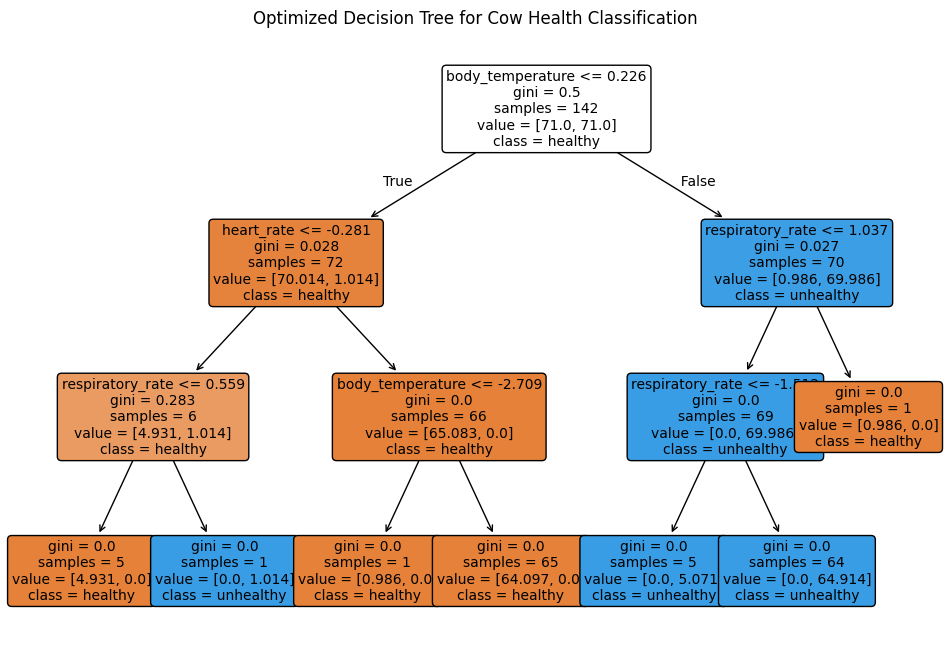


Decision Tree Prediction for Healthy Cow: healthy
Probability: Healthy=100.00%, Unhealthy=0.00%

Decision Tree Prediction for Unhealthy Cow: healthy
Probability: Healthy=100.00%, Unhealthy=0.00%


In [6]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import sys

# Check scikit-learn version
print(f"scikit-learn version: {sklearn.__version__}")

# Load dataset with error handling
try:
    df = pd.read_excel('/cattle_dataset.xlsx')
except FileNotFoundError:
    print("Error: Dataset file not found. Please check the path.")
    sys.exit(1)

# Handle missing values
if df.isnull().sum().any():
    print("Missing values detected. Filling with median for numeric columns...")
    df.fillna(df.median(numeric_only=True), inplace=True)

# Encode target variable
le = LabelEncoder()
try:
    df['health_status_encoded'] = le.fit_transform(df['health_status'])
except KeyError:
    print("Error: 'health_status' column not found in dataset.")
    sys.exit(1)

# Feature selection
features = ['heart_rate', 'respiratory_rate', 'body_temperature']
try:
    X = df[features]
except KeyError:
    print("Error: One or more features not found in dataset.")
    sys.exit(1)
y = df['health_status_encoded']

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning for Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
grid_search_dt = GridSearchCV(dt_model, dt_param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_dt.fit(X_train_scaled, y_train)

# Best Decision Tree model
best_dt_model = grid_search_dt.best_estimator_
print("Best Decision Tree Parameters:", grid_search_dt.best_params_)

# Evaluate Decision Tree
y_pred_dt = best_dt_model.predict(X_test_scaled)
print("\nDecision Tree Classification Report:\n")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))
if len(le.classes_) == 2:
    y_pred_proba_dt = best_dt_model.predict_proba(X_test_scaled)[:, 1]
    print("Decision Tree ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_dt))

# Cross-validation score
cv_scores_dt = cross_val_score(best_dt_model, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
print("\nDecision Tree Cross-Validation F1-Weighted Scores:", cv_scores_dt)
print("Mean CV F1-Weighted Score:", cv_scores_dt.mean())

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Decision Tree):\n", feature_importance)

# Visualize Decision Tree
plt.figure(figsize=(12, 8))
from sklearn.tree import plot_tree
plot_tree(best_dt_model, filled=True, feature_names=features, class_names=le.classes_, rounded=True, fontsize=10)
plt.title("Optimized Decision Tree for Cow Health Classification")
plt.show()

# Function to predict cow health
def predict_cow_health(data_point, model, scaler, feature_names, le):
    data_point_df = pd.DataFrame([data_point], columns=feature_names)
    data_point_scaled = scaler.transform(data_point_df)
    prediction = model.predict(data_point_scaled)
    probability = model.predict_proba(data_point_scaled)
    return le.inverse_transform(prediction)[0], probability[0]

# Test predictions
healthy_cow = {'heart_rate': 60, 'respiratory_rate': 30, 'body_temperature': 38.5}
unhealthy_cow = {'heart_rate': 750, 'respiratory_rate': 750, 'body_temperature': 390.5}

pred_healthy_dt, prob_healthy_dt = predict_cow_health(healthy_cow, best_dt_model, scaler, features, le)
print(f"\nDecision Tree Prediction for Healthy Cow: {pred_healthy_dt}")
print(f"Probability: Healthy={prob_healthy_dt[0]:.2%}, Unhealthy={prob_healthy_dt[1]:.2%}")

pred_unhealthy_dt, prob_unhealthy_dt = predict_cow_health(unhealthy_cow, best_dt_model, scaler, features, le)
print(f"\nDecision Tree Prediction for Unhealthy Cow: {pred_unhealthy_dt}")
print(f"Probability: Healthy={prob_unhealthy_dt[0]:.2%}, Unhealthy={prob_unhealthy_dt[1]:.2%}")